# Project 3: Dog Breed Classifier

This project aims to train an image classification model with images of dogs belonging to 133 unique breeds. We will be using a pytorch model for this project.

In [15]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install --upgrade pip
#!pip install smdebug
!pip install -U smdebug jinja2
!pip install torchvision
!pip install jinja2==3.0.3 --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 3.0.3
    Uninstalling Jinja2-3.0.3:
      Successfully uninstalled Jinja2-3.0.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 10.2 MB/s eta 0:00:00
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.1.2
    Uninstalling MarkupSafe-2.1.2:
      Successfully uninstalled MarkupSafe-2.1.2
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 3.1.2
    Uninstalling Jinja2-3.1.2:
      Successfully uninstalled Jinja2-3.1.2


In [16]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

[2023-03-20 07:11:24.482 datascience-1-0-ml-t3-medium-fbbacbd136ea35c00e5ce9203df8:102 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import numpy as np
import pandas as pd

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
#!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
#!unzip dogImages.zip

In [5]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
# batch size
BATCH_SIZE = 32

In [6]:
import sagemaker
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.debugger import DebuggerHookConfig, TensorBoardOutputConfig
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, CategoricalParameter

# set up SageMaker session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

In [7]:
BUCKET = "sumeet-proj3"
!aws s3 mb s3://{BUCKET}

make_bucket failed: s3://sumeet-proj3 An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.


In [8]:
#! aws s3 cp ./dogImages/ s3://{BUCKET}/ --recursive

In [9]:
data_channels = {
                    "train": f"s3://{BUCKET}/train",
                    "valid": f"s3://{BUCKET}/valid",
                    "test": f"s3://{BUCKET}/test"

                }

In [10]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True 
#disable image truncated error

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [11]:
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)


hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([16, 32])
    #"test-batch-size": CategoricalParameter([100,1000]),
    #"epochs": IntegerParameter(4, 8)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [12]:
#TODO: Create estimators for your HPs


from torchvision import transforms
from sagemaker.pytorch import PyTorch
import gzip 
import numpy as np
import random
import os

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/p3"

role = sagemaker.get_execution_role()

local_dir = 'dogImages'

In [13]:

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Running on Device {device}")


Running on Device cpu


In [14]:
#inputs = sagemaker_session.upload_data(path="local_dir", bucket=bucket, key_prefix=prefix)
#print("input spec (in this case, just an S3 path): {}".format(inputs))

#estimator = # TODO: Your estimator here

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.p2.xlarge"
)

In [17]:
#tuner = # TODO: Your HP tuner here

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=1,
    objective_type=objective_type,
)

# NO NEED TO RUN ESTIMATOR.FIT() AND TUNER.FIT() CELLS BELOW

In [19]:
#testing out by just running the estimator before running the tuner

#estimator.fit(data_channels, wait=True)

In [20]:
# TODO: Fit your HP Tuner
#tuner.fit() # TODO: Remember to include your data channels

tuner.fit(data_channels, wait=True)


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [24]:
#best training job, best estimator, and the best HPs
best_training_job = tuner.best_training_job()
best_training_job

'pytorch-training-230317-1710-001-1cbba54d'

# 'pytorch-training-230317-1710-001-1cbba54d'

In [25]:
best_estimator = tuner.best_estimator()
best_estimator


2023-03-17 17:27:45 Starting - Preparing the instances for training
2023-03-17 17:27:45 Downloading - Downloading input data
2023-03-17 17:27:45 Training - Training image download completed. Training in progress.
2023-03-17 17:27:45 Uploading - Uploading generated training model
2023-03-17 17:27:45 Completed - Resource reused by training job: pytorch-training-230317-1710-002-8639fed8


# <sagemaker.pytorch.estimator.PyTorch at 0x7f0e4d478ed0>

In [26]:
#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"32"',
 'lr': '0.0036613232228599303',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-03-17-17-10-18-137"',
 'sagemaker_program': '"train_model.py"',
 'sagemaker_region': '"us-west-2"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-west-2-981173689685/pytorch-training-2023-03-17-17-10-18-137/source/sourcedir.tar.gz"'}

# 
{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"32"',
 'lr': '0.0036613232228599303',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-03-17-17-10-18-137"',
 'sagemaker_program': '"train_model.py"',
 'sagemaker_region': '"us-west-2"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-west-2-981173689685/pytorch-training-2023-03-17-17-10-18-137/source/sourcedir.tar.gz"'}
 #

# NO NEED TO RUN ESTIMATOR.FIT() AND TUNER.FIT() CELLS ABOVE
# JUST RUN THE CELLS BELOW

# saved training job name

In [27]:
training_job_name = 'pytorch-training-230317-1710-001-1cbba54d'

# saved estimator

In [28]:
#For training jobs, use this code to attach a complted training job:
from sagemaker.pytorch import PyTorch
estimator = PyTorch.attach('pytorch-training-230317-1710-001-1cbba54d')


2023-03-17 17:27:45 Starting - Preparing the instances for training
2023-03-17 17:27:45 Downloading - Downloading input data
2023-03-17 17:27:45 Training - Training image download completed. Training in progress.
2023-03-17 17:27:45 Uploading - Uploading generated training model
2023-03-17 17:27:45 Completed - Resource reused by training job: pytorch-training-230317-1710-002-8639fed8


In [29]:
best_estimator = estimator
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"32"',
 'lr': '0.0036613232228599303',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-03-17-17-10-18-137"',
 'sagemaker_program': '"train_model.py"',
 'sagemaker_region': '"us-west-2"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-west-2-981173689685/pytorch-training-2023-03-17-17-10-18-137/source/sourcedir.tar.gz"'}

In [32]:
# best hyperparameters found
"""
{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"32"',
 'lr': '0.0036613232228599303',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-03-17-17-10-18-137"',
 'sagemaker_program': '"train_model.py"',
 'sagemaker_region': '"us-west-2"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-west-2-981173689685/pytorch-training-2023-03-17-17-10-18-137/source/sourcedir.tar.gz"'}
 """

'\n{\'_tuning_objective_metric\': \'"average test loss"\',\n \'batch-size\': \'"32"\',\n \'lr\': \'0.0036613232228599303\',\n \'sagemaker_container_log_level\': \'20\',\n \'sagemaker_estimator_class_name\': \'"PyTorch"\',\n \'sagemaker_estimator_module\': \'"sagemaker.pytorch.estimator"\',\n \'sagemaker_job_name\': \'"pytorch-training-2023-03-17-17-10-18-137"\',\n \'sagemaker_program\': \'"train_model.py"\',\n \'sagemaker_region\': \'"us-west-2"\',\n \'sagemaker_submit_directory\': \'"s3://sagemaker-us-west-2-981173689685/pytorch-training-2023-03-17-17-10-18-137/source/sourcedir.tar.gz"\'}\n '

# saved tuner

In [33]:
#For hyperparameter tuning jobs:
from sagemaker.tuner import HyperparameterTuner
tuner = HyperparameterTuner.attach('pytorch-training-230317-1710')

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [18]:
# Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

In [19]:
# Set up debugging hook
debugger_config = DebuggerHookConfig(
                    s3_output_path = f"s3://{BUCKET}/output/",
                    hook_parameters={"train.save_interval": "8", "eval.save_interval": "1"},
                    collection_configs = [
                                    CollectionConfig(
                                        name="CrossEntopyLoss_output",
                                        parameters={
                                            "include_regex": "CrossEntropyLoss_output.*",
                                            "train.save_interval": "1",
                                            "eval.save_interval": "1",
                                            "predict.save_interval": "1"
                                                    },
                                                    )
                                        ]
                                    )

In [20]:
# Set up profiling hook
profiler_config = ProfilerConfig(
                        system_monitor_interval_millis=500,
                        framework_profile_params=FrameworkProfile(num_steps=10)
                                )

In [21]:
# best hyperparameters based on tuning results above in best_estimator.hyperparameters()

best_hyperparameters = {"batch-size": "32", "lr": "0.0036613232228599303"}

In [22]:
# TODO: Create and fit an estimator

# estimator = # TODO: Your estimator here

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.p2.xlarge",
    entry_point="train_model.py", 
    framework_version="1.8",
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

# NO NEED TO RUN THE ESTIMATOR.FIT() CELL BELOW AGAIN

In [23]:
estimator.fit(data_channels, wait=True)
#running on 10 epochs with best hyperparameters

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-03-20-07-13-15-618


2023-03-20 07:13:17 Starting - Starting the training job...
2023-03-20 07:13:47 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-03-20 07:14:48 Downloading - Downloading input data......
2023-03-20 07:15:56 Training - Downloading the training image........................
2023-03-20 07:19:50 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-20 07:20:06,698 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-20 07:20:06,721 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-20 07:20:06,724 sagemaker_pytorch_container.training INFO     Invoking user train

In [24]:
estimator

In [25]:
os.listdir(path='/opt/ml')

['metadata']

# Estimator using best hyperparameters 
# <sagemaker.pytorch.estimator.PyTorch at 0x7f7ab07dea10>

In [26]:
estimator.hyperparameters()

{'batch-size': '"32"',
 'lr': '"0.0036613232228599303"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-west-2-981173689685/pytorch-training-2023-03-20-07-13-15-618/source/sourcedir.tar.gz"',
 'sagemaker_program': '"train_model.py"',
 'sagemaker_container_log_level': '20',
 'sagemaker_job_name': '"pytorch-training-2023-03-20-07-13-15-618"',
 'sagemaker_region': '"us-west-2"'}

"""
{'batch-size': '"32"',
 'lr': '"0.0036613232228599303"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-west-2-981173689685/pytorch-training-2023-03-20-07-13-15-618/source/sourcedir.tar.gz"',
 'sagemaker_program': '"train_model.py"',
 'sagemaker_container_log_level': '20',
 'sagemaker_job_name': '"pytorch-training-2023-03-20-07-13-15-618"',
 'sagemaker_region': '"us-west-2"'}
 """

In [28]:
estimator_besthp_training_job_name = 'pytorch-training-2023-03-20-07-13-15-618'

# Save the new estimator with best HPs

In [29]:
#For training jobs, use this code to attach a complted training job:
from sagemaker.pytorch import PyTorch
estimator_new = PyTorch.attach('pytorch-training-2023-03-20-07-13-15-618')



2023-03-20 08:24:59 Starting - Preparing the instances for training
2023-03-20 08:24:59 Downloading - Downloading input data
2023-03-20 08:24:59 Training - Training image download completed. Training in progress.
2023-03-20 08:24:59 Uploading - Uploading generated training model
2023-03-20 08:24:59 Completed - Training job completed


In [30]:
estimator_new

In [31]:
estimator = estimator_new
estimator

In [32]:
# TODO: Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

In [33]:
session = boto3.session.Session()
region = session.region_name

In [34]:
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")


Training jobname: pytorch-training-2023-03-20-07-13-15-618
Region: us-west-2


In [35]:
debut_output_path_generated = estimator.latest_job_debugger_artifacts_path()


In [36]:
print(debut_output_path_generated)

#if NONE, then hardcode the path below

None


In [37]:
#hardcoded debug output path
debug_output_path = "s3://sumeet-proj3/output/pytorch-training-2023-03-20-07-13-15-618/debug-output/"
print(debug_output_path)

s3://sumeet-proj3/output/pytorch-training-2023-03-20-07-13-15-618/debug-output/


In [38]:
trial = create_trial(debug_output_path)


[2023-03-20 08:31:55.519 datascience-1-0-ml-t3-medium-fbbacbd136ea35c00e5ce9203df8:102 INFO s3_trial.py:42] Loading trial  at path s3://sumeet-proj3/output/pytorch-training-2023-03-20-07-13-15-618/debug-output/
[2023-03-20 08:31:57.528 datascience-1-0-ml-t3-medium-fbbacbd136ea35c00e5ce9203df8:102 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 4574 more expected)', IncompleteRead(0 bytes read, 4574 more expected)) while reading s3://sumeet-proj3/output/pytorch-training-2023-03-20-07-13-15-618/debug-output/index/000000000/000000000000_worker_0.json . Will retry now


In [39]:
print(trial.tensor_names())

[2023-03-20 08:33:40.426 datascience-1-0-ml-t3-medium-fbbacbd136ea35c00e5ce9203df8:102 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-03-20 08:33:41.446 datascience-1-0-ml-t3-medium-fbbacbd136ea35c00e5ce9203df8:102 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.1.relu_input_2', 'layer2.2.relu_input_0', 'layer2.2.relu_input_1', 'layer2.2.relu_input_2', 'layer2.3.relu_input_0', 'layer2.3.relu_input_1', 'layer2.3.relu_input_2', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.0.relu_input_2', 'layer3.1.relu_input_0'

#

In [40]:
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

5225
675


In [43]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts



tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-west-2-981173689685/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-west-2-981173689685/pytorch-training-2023-03-20-07-13-15-618/profiler-output


Profiler data from system is available


In [44]:
system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

In [45]:
view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2023-03-20 08:45:10.454 datascience-1-0-ml-t3-medium-fbbacbd136ea35c00e5ce9203df8:102 INFO metrics_reader_base.py:134] Getting 71 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'GPUMemoryUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1'}


In [46]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-west-2-981173689685/pytorch-training-2023-03-20-07-13-15-618/rule-output


# You will find the profiler report in 
s3://sagemaker-us-west-2-981173689685/pytorch-training-2023-03-20-07-13-15-618/rule-output

In [47]:
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

2023-03-20 08:24:28     427758 pytorch-training-2023-03-20-07-13-15-618/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-03-20 08:24:27     284545 pytorch-training-2023-03-20-07-13-15-618/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-03-20 08:24:22        192 pytorch-training-2023-03-20-07-13-15-618/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-03-20 08:24:22      68796 pytorch-training-2023-03-20-07-13-15-618/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-03-20 08:24:22       2145 pytorch-training-2023-03-20-07-13-15-618/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-03-20 08:24:23        317 pytorch-training-2023-03-20-07-13-15-618/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-03-20 08:24:23       3212 pytorch-training-2023-03-20-07-13-15-618/rule-output/ProfilerReport/profiler-output/profiler-re

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [48]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]


In [50]:
# TODO: Display the profiler output
import IPython

#IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

#commented out to avoid the whiteout of UI in sagemaker

In [51]:
trial.tensor_names()

['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.relu_input_2',
 'layer3.4.relu_input_0',
 'layer3.4.relu_input_1'

In [52]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

5225

In [53]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

675

In [134]:
tensor = trial.tensor("CrossEntropyLoss_output_0")
tensor

In [144]:
steps_train = tensor.steps(mode=ModeKeys.TRAIN)
#steps

In [161]:
steps_eval = tensor.steps(mode=ModeKeys.EVAL)
#steps

In [145]:
vals_train = []

In [162]:
vals_eval = []


In [169]:
for s in range(0,len(steps_train),10):
    vals_train.append(tensor.value(s, mode=ModeKeys.TRAIN))    
    

In [170]:
for s in range(0,len(steps_eval),10):
    vals_eval.append(tensor.value(s, mode=ModeKeys.EVAL))    
    

In [171]:
len(vals_train)

576

In [172]:
len(vals_eval)

75

In [153]:
vals_train

[array(5.009566, dtype=float32),
 array(0.95725554, dtype=float32),
 array(0.9966016, dtype=float32),
 array(0.28850043, dtype=float32),
 array(1.6919382, dtype=float32),
 array(0.36859855, dtype=float32),
 array(1.8036529, dtype=float32),
 array(0.25985378, dtype=float32),
 array(0.11810166, dtype=float32),
 array(0.300251, dtype=float32),
 array(0.26349688, dtype=float32),
 array(0.03887677, dtype=float32),
 array(0.49853358, dtype=float32),
 array(0.5699969, dtype=float32),
 array(0.32607603, dtype=float32),
 array(0.26853138, dtype=float32),
 array(0.13847414, dtype=float32),
 array(0.16172914, dtype=float32),
 array(0.39200395, dtype=float32),
 array(0.24477185, dtype=float32),
 array(0.185363, dtype=float32),
 array(0.28303203, dtype=float32),
 array(0.3386295, dtype=float32),
 array(0.14932819, dtype=float32),
 array(0.20369571, dtype=float32),
 array(0.2099469, dtype=float32),
 array(0.36205637, dtype=float32),
 array(0.6411714, dtype=float32),
 array(0.17651889, dtype=float32)

In [165]:
vals_eval

[array(1.3863211, dtype=float32),
 array(0.97049654, dtype=float32),
 array(0.53898865, dtype=float32),
 array(1.5165228, dtype=float32),
 array(1.3567877, dtype=float32),
 array(1.7638593, dtype=float32),
 array(1.4243252, dtype=float32)]

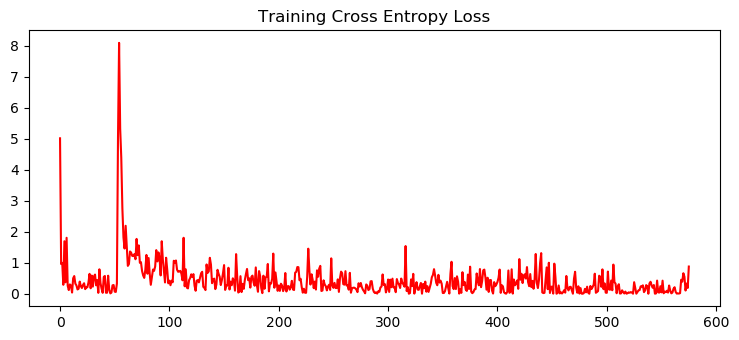

In [173]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title("Training Cross Entropy Loss")
plt.plot(vals_train, color="red")
plt.show()

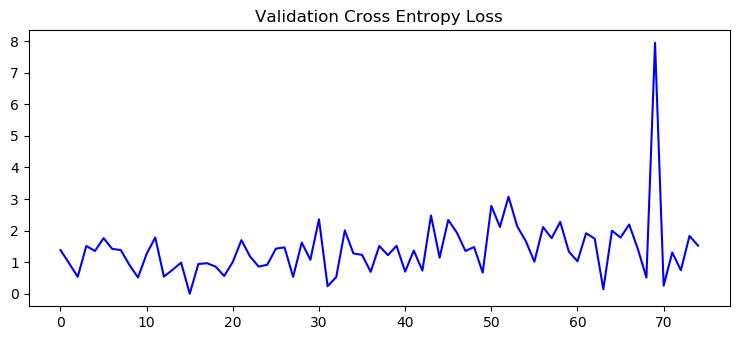

In [174]:
import matplotlib.pyplot as plt2
plt2.rcParams["figure.figsize"] = [7.50, 3.50]
plt2.rcParams["figure.autolayout"] = True
plt2.title("Validation Cross Entropy Loss")
plt2.plot(vals_eval, color="blue")
plt2.show()

## Model Deploying

In [58]:
# TODO: Deploy your model to an endpoint

#predictor=estimator.deploy() # TODO: Add your deployment configuration like instance type and number of instances
#predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium")
predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.p2.xlarge")




INFO:sagemaker:Creating model with name: pytorch-training-2023-03-20-09-00-55-267
INFO:sagemaker:Creating endpoint-config with name pytorch-training-2023-03-20-09-00-55-267
INFO:sagemaker:Creating endpoint with name pytorch-training-2023-03-20-09-00-55-267


-----------!

In [59]:
endpoint_name = predictor.endpoint_name

In [60]:
endpoint_name

'pytorch-training-2023-03-20-09-00-55-267'

# Endpoint Name is:

'pytorch-training-2023-03-20-09-00-55-267'

# To reload predictor using the endpoint name

In [61]:
predictor = sagemaker.pytorch.model.PyTorchPredictor(endpoint_name)

# Prepare and Send a Test Image To Endpoint

In [62]:
from train_model import create_data_loaders

/opt/conda/lib/python3.7/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


WARNING: The directory '/root/.cache/pip' or its parent directory is not owned or is not writable by the current user. The cache has been disabled. Check the permissions and owner of that directory. If executing pip with sudo, you should use sudo's -H flag.


Requirement already satisfied: smdebug in /opt/conda/lib/python3.7/site-packages (1.0.12)

Requirement already satisfied: boto3>=1.10.32 in /opt/conda/lib/python3.7/site-packages (from smdebug) (1.26.91)

Requirement already satisfied: protobuf>=3.6.0 in /opt/conda/lib/python3.7/site-packages (from smdebug) (3.20.3)

Requirement already satisfied: pyinstrument==3.4.2 in /opt/conda/lib/python3.7/site-packages (from smdebug) (3.4.2)

Requirement already satisfied: packaging in /opt/conda/lib/python3.7/site-packages (from smdebug) (20.1)

Requirement already satisfied: numpy>=1.16.0 in /opt/conda/lib/python3.7/site-packages (from smdebug) (1.21.6)

Requirement already satisfied: pyinstrument-cext>=0.2.2 in /opt/conda/lib/python3.7/site-packages (from pyinstrument==3.4.2->smdebug) (0.2.4)

Requirement already satisfied: botocore<1.30.0,>=1.29.91 in /opt/conda/lib/python3.7/site-packages (from boto3>=1.10.32->smdebug) (1.29.91)

Requirement already satisfied: jmespath<2.0.0,>=0.7.1 in /opt/conda/lib/python3.7/site-packages (from boto3>=1.10.32->smdebug) (1.0.1)

Requirement already satisfied: s3transfer<0.7.0,>=0.6.0 in /opt/conda/lib/python3.7/site-packages (from boto3>=1.10.32->smdebug) (0.6.0)

Requirement already satisfied: pyparsing>=2.0.2 in /opt/conda/lib/python3.7/site-packages (from packaging->smdebug) (2.4.6)

Requirement already satisfied: six in /opt/conda/lib/python3.7/site-packages (from packaging->smdebug) (1.14.0)

Requirement already satisfied: python-dateutil<3.0.0,>=2.1 in /opt/conda/lib/python3.7/site-packages (from botocore<1.30.0,>=1.29.91->boto3>=1.10.32->smdebug) (2.8.2)

Requirement already satisfied: urllib3<1.27,>=1.25.4 in /opt/conda/lib/python3.7/site-packages (from botocore<1.30.0,>=1.29.91->boto3>=1.10.32->smdebug) (1.26.15)

WARNING: Running pip as the 'root' user can result in broken permissions and conflicting behaviour with the system package manager. It is recommended to use a virtual environment instead: https://pip.pypa.io/warnings/venv


[2023-03-20 09:07:44.774 datascience-1-0-ml-t3-medium-fbbacbd136ea35c00e5ce9203df8:102 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


In [98]:
test_loader = create_data_loaders("./dogImages/test/", 1)

In [117]:
for images, labels in test_loader:
    break

In [118]:
images.shape

torch.Size([1, 3, 224, 224])

In [119]:
labels

tensor([89])

In [108]:
# i sent the test image with label 89 to endpoint

In [120]:
# TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(images)


In [121]:
response

array([[-36.27040482, -38.31533051, -63.20485687, -51.42645264,
        -48.33810043, -55.54640579, -30.12886047,  -3.47850919,
        -60.53120422, -23.4191494 , -43.14960098, -43.8575592 ,
        -68.04586029, -37.29469681, -39.09386063, -55.7818222 ,
        -41.12189484, -26.95534706, -41.6945343 , -25.8725872 ,
        -50.57231903, -60.69184113, -71.33926392, -48.1852684 ,
        -54.10617828, -58.07958984, -67.05476379, -63.02248383,
        -45.25099564, -48.40805435, -17.64297676, -28.69466591,
        -50.90484238, -18.0474205 , -42.62445068, -59.00087738,
        -71.05610657, -43.73062134, -14.27247715, -18.44313431,
        -37.22671127, -40.02329254, -18.11982155, -33.00933456,
        -27.73017693, -45.08397675, -39.87943268, -31.22255898,
         -4.93486691, -34.08206558, -72.90209961, -53.27164841,
        -35.11133957, -53.00069046, -21.98107147, -45.6791153 ,
        -41.36084366, -67.41096497, -23.05523682, -36.50272369,
        -56.60215759, -46.22170639, -34.

In [122]:
best_breed_index = np.argmax(response)
best_breed_index

89

The endpoint predicted the class 89

In [123]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
data = ImageFolder(root='./dogImages/train', transform=ToTensor())

In [124]:
print(data.classes) 
# to get the names of classes i.e. dog breeds

['001.Affenpinscher', '002.Afghan_hound', '003.Airedale_terrier', '004.Akita', '005.Alaskan_malamute', '006.American_eskimo_dog', '007.American_foxhound', '008.American_staffordshire_terrier', '009.American_water_spaniel', '010.Anatolian_shepherd_dog', '011.Australian_cattle_dog', '012.Australian_shepherd', '013.Australian_terrier', '014.Basenji', '015.Basset_hound', '016.Beagle', '017.Bearded_collie', '018.Beauceron', '019.Bedlington_terrier', '020.Belgian_malinois', '021.Belgian_sheepdog', '022.Belgian_tervuren', '023.Bernese_mountain_dog', '024.Bichon_frise', '025.Black_and_tan_coonhound', '026.Black_russian_terrier', '027.Bloodhound', '028.Bluetick_coonhound', '029.Border_collie', '030.Border_terrier', '031.Borzoi', '032.Boston_terrier', '033.Bouvier_des_flandres', '034.Boxer', '035.Boykin_spaniel', '036.Briard', '037.Brittany', '038.Brussels_griffon', '039.Bull_terrier', '040.Bulldog', '041.Bullmastiff', '042.Cairn_terrier', '043.Canaan_dog', '044.Cane_corso', '045.Cardigan_welsh_

In [125]:
data.classes[best_breed_index]
#to name the breed predicted by the endpoint

'090.Italian_greyhound'

The corresponding breed is 090.Italian_greyhound

# Let's try another test image

In [126]:
for images2, labels2 in test_loader:
    break

In [127]:
labels2

tensor([12])

In [91]:
# the image i am sending for testing now has a label 12

In [128]:
response2 = predictor.predict(images2)

In [129]:
best_breed_index2 = np.argmax(response2)
best_breed_index2

12

The response from the endpoint is also 12

In [130]:
data.classes[best_breed_index2]

'013.Australian_terrier'

The corresponding breed is 013.Australian_terrier

# Delete Endpoint

In [82]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

Deleting endpoint configuration with name: pytorch-training-2023-03-19-11-51-25-481

Deleting endpoint with name: pytorch-training-2023-03-19-11-51-25-481